In [1]:
from datetime import datetime
import logging
import os
import random
import math

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms

from mylogger import create_logger
from net.mobilenetv3 import MobileNetV3Large, MobileNetV3Small
from trainer import ClassifierTrainer as Trainer
import utils
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 1760
NUM_WORKERS = 96
EPOCHS = 30

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
normalizer = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(3),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3,
                           contrast=0.3,
                           saturation=0.3,
                           hue=0.1),
    transforms.ToTensor(),
    utils.Cutout(20),
    normalizer
])

transform_valid = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalizer
])

train_val_dataset = torchvision.datasets.ImageFolder(
    './data/imagenet/train', transform=transform_train
)

# Create validation dataset
dataset_size = len(train_val_dataset)
indices = list(range(dataset_size))
random.shuffle(indices)

train_indices = indices[50000:]
valid_indices = indices[:50000]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


In [4]:
valid_loader = DataLoader(
    train_val_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=NUM_WORKERS
)

In [5]:
# Credit: https://medium.com/coinmonks/training-neural-networks-upto-10x-faster-3246d84caacd
def findLR(model, optimizer, criterion, trainloader, final_value=10, init_value=1e-8):
    '''
      findLR plots the graph for the optimum learning rates for the model with the 
      corresponding dataset.
      The technique is quite simple. For one epoch,
      1. Start with a very small learning rate (around 1e-8) and increase the learning rate linearly.
      2. Plot the loss at each step of LR.
      3. Stop the learning rate finder when loss stops going down and starts increasing.
      
      A graph is created with the x axis having learning rates and the y axis
      having the losses.
      
      Arguments:
      1. model -  (torch.nn.Module) The deep learning pytorch network.
      2. optimizer: (torch.optim) The optimiser for the model eg: SGD,CrossEntropy etc
      3. criterion: (torch.nn) The loss function that is used for the model.
      4. trainloader: (torch.utils.data.DataLoader) The data loader that loads data in batches for input into model 
      5. final_value: (float) Final value of learning rate
      6. init_value: (float) Starting learning rate.
      
      Returns:
       Nothing
       
      Plots a matplotlib graph
      
    '''
    model.train() # setup model for training configuration
    
    num = len(trainloader) - 1 # total number of batches
    mult = (final_value / init_value) ** (1/num)
    
    losses = []
    lrs = []
    best_loss = 0.
    avg_loss = 0.
    beta = 0.98 # the value for smooth losses
    lr = init_value
    
    for batch_num, (inputs, targets) in enumerate(trainloader):
        
        
        optimizer.param_groups[0]['lr'] = lr
        
        batch_num += 1 # for non zero value
        inputs, targets = inputs.to(device), targets.to(device) # convert to cuda for GPU usage
        optimizer.zero_grad() # clear gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, targets) # compute loss
       
        #Compute the smoothed loss to create a clean graph
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        # append loss and learning rates for plotting
        lrs.append(math.log10(lr))
        losses.append(smoothed_loss)
        
        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break
        
        # backprop for next step
        loss.backward()
        optimizer.step()
        
        # update learning rate
        lr = mult*lr
        
    plt.xlabel('Learning Rates')
    plt.ylabel('Losses')
    plt.plot(lrs,losses)
    plt.show()

In [6]:
model = MobileNetV3Large(n_classes=1000).to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)

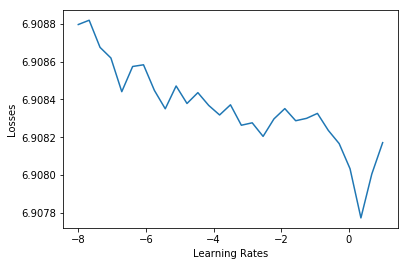

In [7]:
findLR(model, optimizer, criterion, valid_loader)